# Predict TripAdvisor Rating

# import

In [9]:
import numpy as np
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from datetime import datetime
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
plt.show()
sns.set()
pd.set_option('display.max_columns', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# Фиксирую RANDOM_SEED для воспроизводимости экспериментов!
RANDOM_SEED = 42

In [5]:
# зафиксирую версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [12]:
DATA_DIR = 'C:/Users/ondar/SF/SkillFactory/Unit_3_ModelML/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [13]:
# Для корректной обработки признаков объединяю трейн и тест в один датасет

df_train['sample'] = 1  # помечаю где трейн
df_test['sample'] = 0  # помечаю где тест

# в тесте нет значения Rating, оно должно быть предсказано в ходе экспериментов, поэтому пока просто заполняем нулями
df_test['Rating'] = 0

# объединяю
df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  

In [ ]:
df.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
df.sample(5)

In [ ]:
df.Reviews[1]

Как видно, большинство признаков требует очистки и предварительной обработки.

# Cleaning and Prepping Data

In [2]:
df = pd.read_csv('main_task.csv')
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
# Переименуем столбцы датасета для удобства работы
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta']
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [4]:
# Определим общее кол-во строк и столбцов датасета проекта
print('Датасет проекта содержит {} строк, {} столбцов\n'.format(df.shape[0], df.shape[1]))

Датасет проекта содержит 40000 строк, 10 столбцов



In [4]:
# Определим кол-во столбцов, содержащих пустые значения
print(f'В {df.isnull().any().sum()} столбцах есть отсутствующие значения.\n')

# Посмотрим абс и относит величину пропущенных значений по каждому признаку
cols_isnan=pd.DataFrame({'count': df.isnull().sum(),
                              'ratio': df.isnull().sum()/len(df)}).query('count > 0')
print('Признаки, в которых есть данные с пропущенными значениями\n\n{}'
      .format(cols_isnan))

В 3 столбцах есть отсутствующие значения.

Признаки, в которых есть данные с пропущенными значениями

                   count     ratio
cuisine_style       9283  0.232075
price_range        13886  0.347150
number_of_reviews   2543  0.063575


### 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN выделю информацию о наличии пропуска как отдельный признак

In [5]:
'''Создаю функцию по обработке признаков, содержащих NaN
(выделение информации о наличии пропуска как отдельный признак, 
вывод 10-ти самых часто встречающихся уникальных значений. 
Хотела, чтобы для количественных и для категориальных признаков формировался график, но начала вылезать ошибка с price_range, 
поэтому визуализацию убрала).
'''


def viewing_nan_features(df, column):
    print(column, '\n', pd.DataFrame({'count': df[column].value_counts(dropna=False),
                        'ratio': df[column].value_counts(dropna=False, normalize=True)}).head(10),'\n')
    if df[column].isnull().any() == True:
        df[df[column].name+'_isNAN'] = pd.isna(df[column]).astype('uint8')
        
#     if df[column].dtype=='float':
#         return sns.distplot(df[column])
#     elif df[column].dtype=='O':
#         return df[column].hist()#sns.catplot(x=column, data=df, kind='bar')

## New features - признаки, указывающие наличие пропусков:

In [6]:
new_features = []
for i in cols_isnan.index.tolist():
    viewing_nan_features(df, i)
    new_features.append(i+'_isNAN')
df[cols_isnan.index.tolist()+new_features].head(10)

cuisine_style 
                             count     ratio
NaN                          9283  0.232075
['Italian']                  1032  0.025800
['French']                    805  0.020125
['Spanish']                   695  0.017375
['French', 'European']        405  0.010125
['Cafe']                      403  0.010075
['Pizza']                     371  0.009275
['Italian', 'Pizza']          343  0.008575
['European', 'Portuguese']    342  0.008550
['Chinese']                   328  0.008200 

price_range 
           count     ratio
$$ - $$$  18412  0.460300
NaN       13886  0.347150
$          6279  0.156975
$$$$       1423  0.035575 

number_of_reviews 
       count     ratio
NaN    2543  0.063575
2.0    1916  0.047900
3.0    1636  0.040900
4.0    1370  0.034250
5.0    1181  0.029525
6.0    1018  0.025450
7.0     890  0.022250
8.0     829  0.020725
9.0     769  0.019225
10.0    688  0.017200 



,cuisine_style,price_range,number_of_reviews,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN
0,"['European', 'French', 'International']",$$ - $$$,194.0,0,0,0
1,NaN,NaN,10.0,1,1,0
2,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",$$$$,688.0,0,0,0
3,NaN,NaN,3.0,1,1,0
4,"['German', 'Central European', 'Vegetarian Fri...",$$ - $$$,84.0,0,0,0
5,NaN,NaN,2.0,1,1,0
6,"['Italian', 'Pizza']",$,50.0,0,0,0
7,['Italian'],NaN,9.0,0,1,0
8,NaN,NaN,NaN,1,1,1
9,"['Italian', 'Pizza', 'Fast Food']",$,55.0,0,0,0


### 2. Обработка признаков

### Рассмотрим столбцы по отдельности.

### 1) city - Город

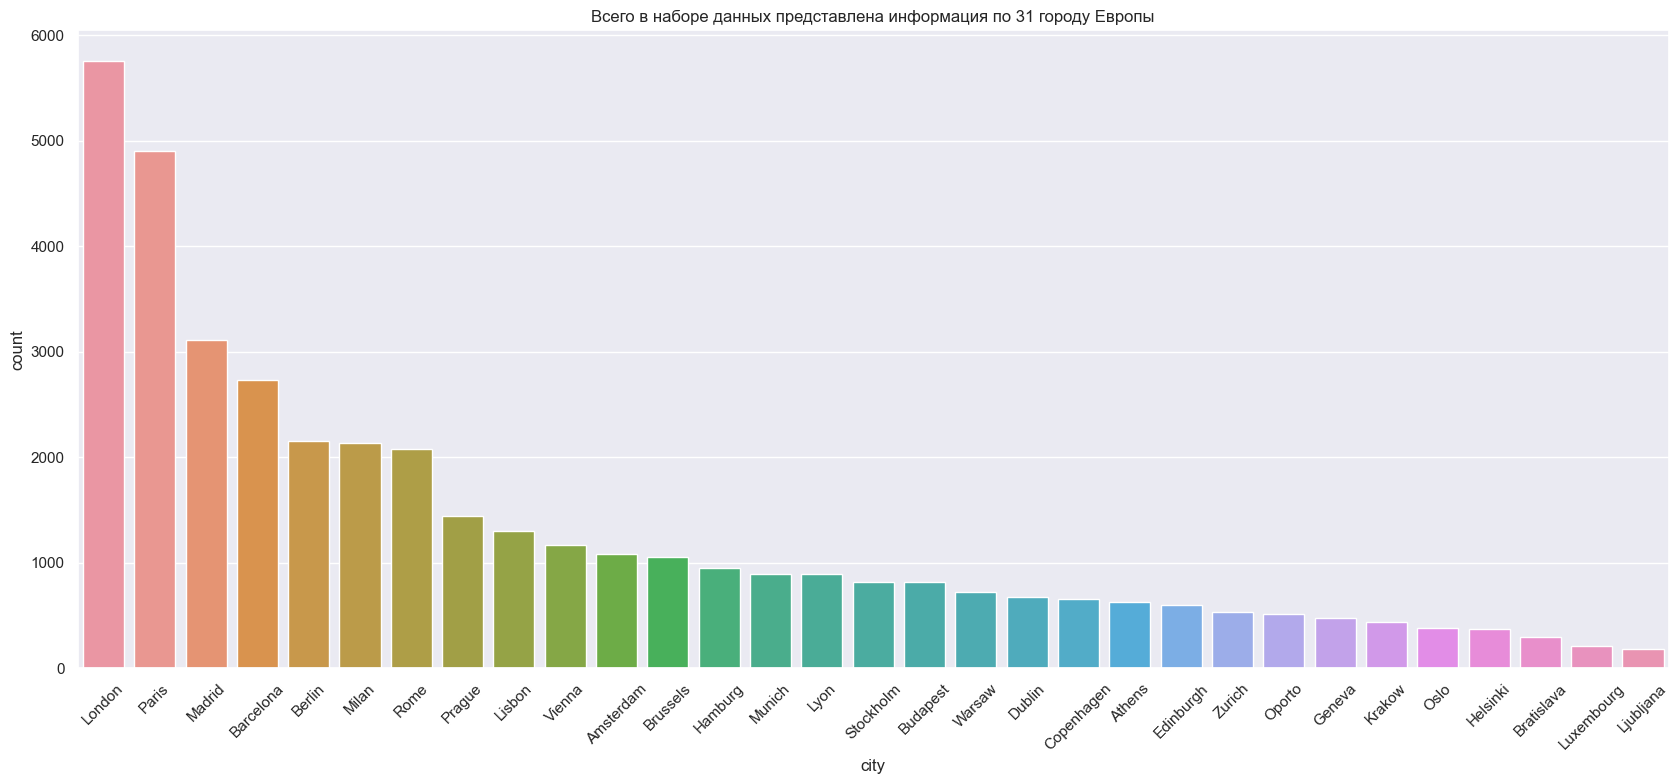

In [7]:
# Выводим количество городов представленных в наборе данных
c = 'Всего в наборе данных представлена информация по ' + str(df.city.nunique()) + \
    ' городу Европы'
plt.figure(figsize=(17, 8), dpi=100)
plot = sns.countplot(df['city'], order=df['city'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title(c)
plt.tight_layout()

In [7]:
df_city = df.groupby('city')
df_city['rating'].mean().sort_values(ascending=False)[:10]

city
Rome         4.230269
Athens       4.230096
Oporto       4.178363
Krakow       4.146727
Amsterdam    4.131215
Berlin       4.124594
Ljubljana    4.112022
Budapest     4.090074
Warsaw       4.089409
Edinburgh    4.088087
Name: rating, dtype: float64

Столбец 'city' без пропусков, категориальный признак. Всего в наборе данных представлена информация по 31 городу Европы.

Посмотрим распределение рейтинга по каждому городу

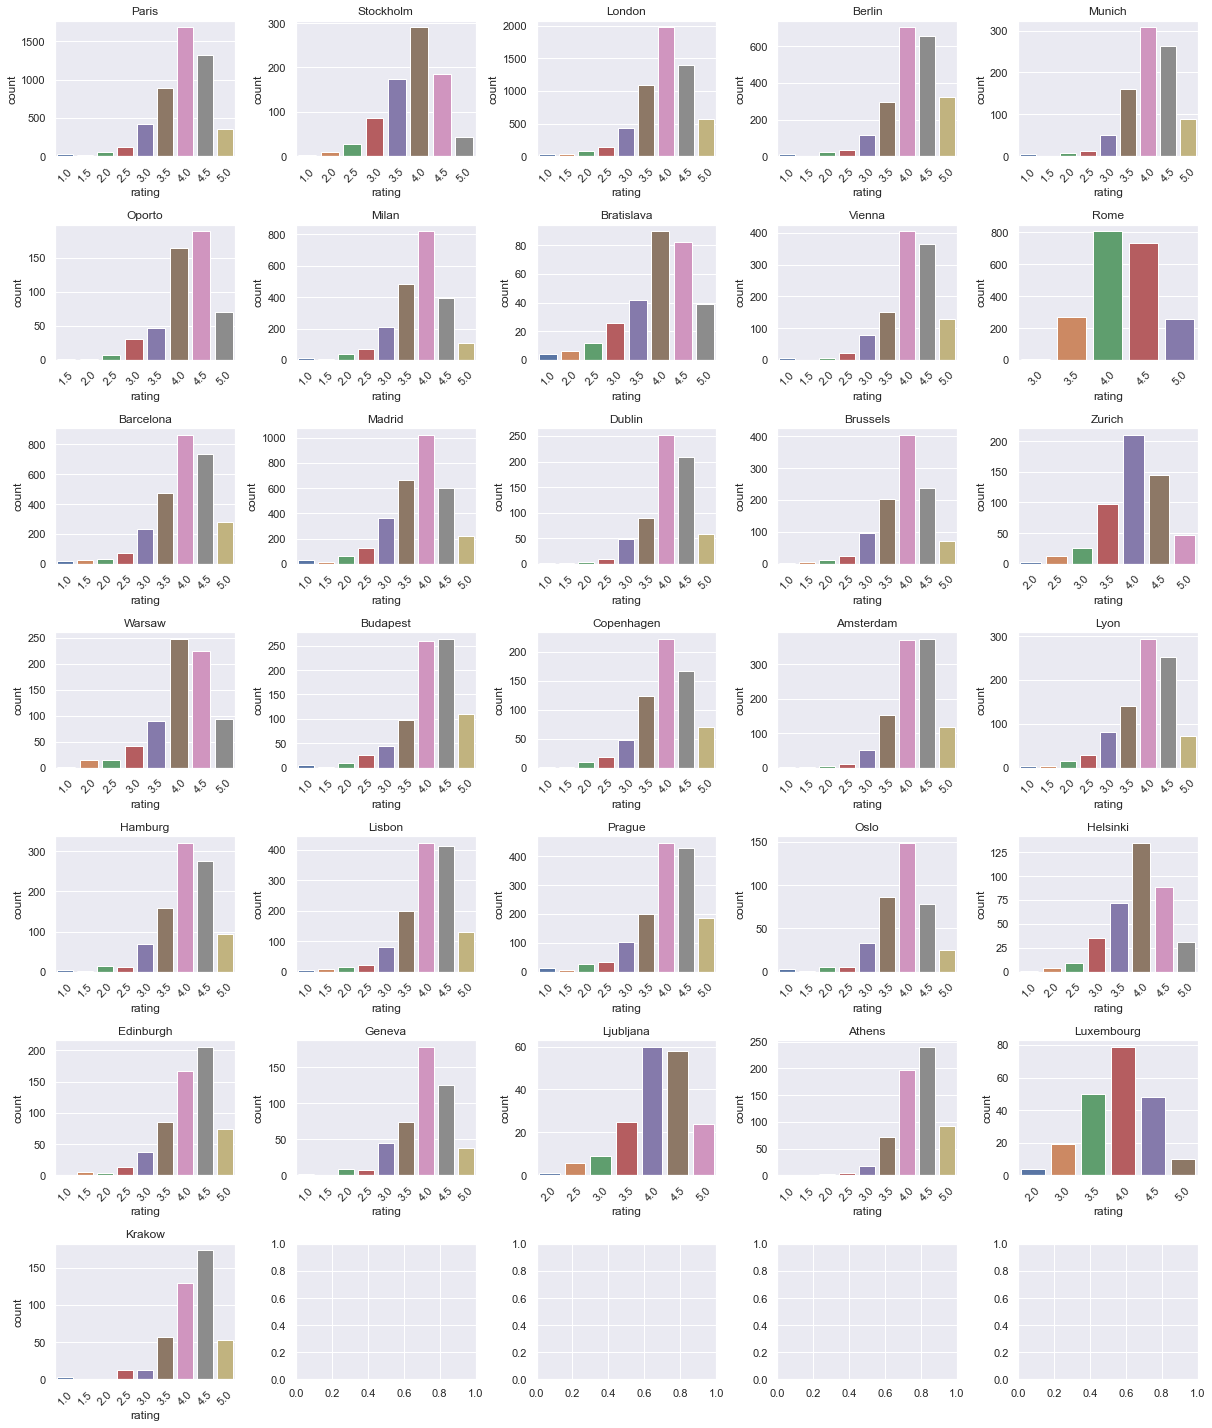

In [8]:
list_city = list(df['city'].unique())
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(17, 20))
i = 0
list_ratings = list(df['rating'].unique())
ratings = list()
for c in list_city:
    df_city = df[df['city'] == c]
    plot = sns.countplot(x='rating', data=df_city, ax=axes.flatten()[i])
    plot.set_title(c)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.tight_layout()
    i = i + 1

### New features
Добавлю новые признаки:  
- capital_city - столица  
- code_country - код страны с помощью LabelEncoder
- city_population - население города (тыс. чел.)
- restaurants_city - количество ресторанов в городе
- restaurants_per_capita - количество ресторанов на 1000 чел. населения города

In [9]:
capitals = ['Mariehamn', 'Tirana', 'Andorra la Vella', 'Vienna',
            'Minsk', 'Brussels', 'Sarajevo', 'Sofia',
            'Zagreb', 'Nicosia', 'Prague', 'Copenhagen',
            'Tallinn', 'Tórshavn', 'Helsinki', 'Paris',
            'Berlin', 'Gibraltar', 'Athens', 'St. Peter Port',
            'Budapest', 'Reykjavik', 'Dublin', 'Douglas',
            'Rome', 'Saint Helier', 'Pristina', 'Riga',
            'Vaduz', 'Vilnius', 'Luxembourg', 'Skopje',
            'Valletta', 'Chișinău', 'Monaco', 'Podgorica',
            'Amsterdam', 'Oslo', 'Warsaw', 'Lisbon',
            'Bucharest', 'Moscow', 'City of San Marino', 'Belgrade',
            'Bratislava', 'Ljubljana', 'Madrid', 'Longyearbyen',
            'Stockholm', 'Bern', 'Kiev', 'London', 'Vatican City']
df['capital_city'] = df.city.apply(lambda x: 1 if x in capitals else 0)

In [10]:
dict_countries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czechia', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Netherlands', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Pr_Luxembourg', 'Ljubljana' : 'Slovenia'}
df['country'] = df.city.map(dict_countries)

le = LabelEncoder()
le.fit(df['country'])
df['code_country'] = le.transform(df['country'])

In [11]:
dict_city_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['city_population'] = df.city.map(dict_city_population)


In [12]:
restaurants_city = df['city'].value_counts(ascending=False)

df['restaurants_city'] = df['city'].apply(lambda x: restaurants_city[x])
df['restaurants_per_capita'] = df['restaurants_city'] / (df['city_population'])

### New feature
Добавлю новый признак - индекс безопасности страны.
- country_gpi

«Глобальный индекс миролюбия» (англ. Global Peace Index) — индекс, разработанный социологами и экономистами из международной группы экспертов по миру Института мира вместе с Центром мира и изучения конфликтов Сиднейского университета, характеризующий, по их мнению, уровень безопасности проживания в странах и регионах. В данном рейтинге не учтены Люксембург и Шотландия. Люксембургу внесу индекс Исландии, которая занимает первую позицию. Шотландии внесу данные UK.

In [13]:
dict_gpi = {'Pr_Luxembourg': 1.078, 'Portugal': 1.247, 'Austria': 1.275, 'Denmark': 1.283, 'Czechia': 1.337, 
                 'Switzerland': 1.366, 'Slovenia': 1.369, 'Ireland': 1.375, 'Finland': 1.404, 'Sweden': 1.479, 
                 'Germany': 1.494, 'Belgium': 1.496, 'Norway': 1.496, 'Netherlands': 1.528, 'Romania': 1.541, 
                 'Slovakia': 1.568, 'Poland': 1.657, 'Italy': 1.69, 'Spain': 1.712, 'England': 1.77, 
                 'Scotland': 1.77, 'Greece': 1.877, 'France': 1.93}

df['country_gpi'] = df.country.map(dict_gpi)

### 2) cuisine_style - Кухня

Категориальный признак. Всего пропусков - 9283, что составляет 23% от всех данных.

In [14]:
# Преобразование типов кухонь для каждого ресторана в список. Пропуски пока не заполняю.
df['cuisine_style'] = df.cuisine_style.apply(lambda x: ast.literal_eval(x) if pd.isnull(x)==False else '')
type(df['cuisine_style'][0])

list

In [16]:
# Посчитаем количество уникальных значений типов кухонь
cuisine = [i for i in df.cuisine_style.explode() if i!='']
set_cuisine = set(cuisine)
print('Всего в датасете представлено {} уникальных типов кухонь'.format(
    len(set_cuisine)), '\n')

# Определим самую популярную кухню:
most_popular_cuisine = Counter(cuisine).most_common()[0]
print('\nCамая популярная кухня:', most_popular_cuisine, '\n')

# Создадим датасет с кухнями и количеством данной кухни в основном датасете для использования при нахождении самых популярных:
counter_cuisine = pd.DataFrame(Counter(cuisine).most_common(), columns=[
                               'cuisine_style', 'count_style'])

# Определим 90 % самых встречаемых типов:
top_cuisines_count = int(np.percentile(
    counter_cuisine.count_style.tolist(), 90))
top_cuisines = counter_cuisine[counter_cuisine.count_style >=
    top_cuisines_count].cuisine_style.tolist()
print('90 % самых встречаемых типов:\n', top_cuisines)

# Определим остальные 10 % типов:
other_cuisines = counter_cuisine[counter_cuisine.count_style <
    top_cuisines_count].cuisine_style.tolist()
print('\nОстальные 10 % типов:\n', other_cuisines)

Всего в датасете представлено 125 уникальных типов кухонь 


Cамая популярная кухня: ('Vegetarian Friendly', 11189) 

90 % самых встречаемых типов:
 ['Vegetarian Friendly', 'European', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza', 'Spanish', 'Pub', 'Cafe']

Остальные 10 % типов:
 ['Fast Food', 'British', 'International', 'Seafood', 'Japanese', 'Central European', 'American', 'Sushi', 'Chinese', 'Portuguese', 'Indian', 'Middle Eastern', 'Thai', 'Wine Bar', 'German', 'Healthy', 'Greek', 'Halal', 'Czech', 'Fusion', 'Steakhouse', 'Barbecue', 'Contemporary', 'Vietnamese', 'Eastern European', 'Soups', 'Grill', 'Gastropub', 'Mexican', 'Turkish', 'Delicatessen', 'Austrian', 'South American', 'Polish', 'Hungarian', 'Scandinavian', 'Lebanese', 'Latin', 'Diner', 'Dutch', 'Irish', 'Belgian', 'Street Food', 'Brew Pub', 'Swiss', 'Danish', 'Swedish', 'Argentinean', 'Korean', 'Scottish', 'African', 'Moroccan', 'Central American', 'Brazilian', 'P

### New features
- is_top_cuisines - кухни из списка самых популярных, остальные - Other
- top_cuisine_style - входит ли кухня данного ресторана в самые популярные (1 - входит, 0 - не входит)
- cuisine_style_count - количество типов кухонь, предлагаемых в одном ресторане
- top_cuisine_count - количество популярных кухонь в одном ресторане, если таковых нет - 0

In [17]:
def is_top_cuisines(val):
    '''
    Возвращаем список кухонь, входящих в список самых распространенных, а иначе - Other
    '''
    top = []
    if val=='':
        return ['Other']
    else:
        top = [i for i in val if i in top_cuisines]
    if len(top):
        return top
    else:
        return ['Other']

df['is_top_cuisines'] = df.cuisine_style.apply(is_top_cuisines)
df.head()


,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,capital_city,country,code_country,city_population,restaurants_city,restaurants_per_capita,country_gpi,is_top_cuisines
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,1,France,6,2206,4897,2.219855,1.930,"[European, French]"
1,id_1535,Stockholm,,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,1,0,1,Sweden,21,961,820,0.853278,1.479,[Other]
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,0,1,England,4,8908,5757,0.646273,1.770,"[Asian, Vegetarian Friendly, Vegan Options, Gl..."
3,id_3456,Berlin,,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,0,1,Germany,7,6010,2155,0.358569,1.494,[Other]
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,0,0,0,Germany,7,1457,893,0.612903,1.494,[Vegetarian Friendly]


Пропуски в cuisine_style заполню значением Other

In [18]:
df['cuisine_style'] = df.cuisine_style.apply(lambda x: ['Other'] if x=='' else x)

In [19]:
df['top_cuisine_style'] = df.apply(lambda x: 1 if len(
    [i for i in x.cuisine_style if i in top_cuisines]) != 0 else 0, axis=1)

df['cuisine_style_count'] = df.cuisine_style.apply(lambda x: len(x))

In [20]:
df['top_cuisine_count'] = df.is_top_cuisines.apply(lambda x: 0 if x=='Other' else len(x))

### 3) price_range: Цены в ресторане в 3 категориях

Категориальный признак. Пропусков очень много - 13886 или 35% от всех данных. 

Попробую посмотреть по каким ресторанам больше всего пропусков

Составлю список ресторанов, по которым есть пропуски в price_range и посмотрю, какие уникальные значения цены есть среди этих ресторанов

In [21]:
list_rest = df[df.price_range.isna()]['restaurant_id'].tolist()

df.query('restaurant_id in @list_rest')['price_range'].value_counts(dropna=False)

NaN         13886
$$ - $$$    12342
$            4285
$$$$          811
Name: price_range, dtype: int64

In [22]:
# Попробую проверить, есть ли среди этих ресторанов такие, у которых по одному id ресторана разные ценовые категории

df.query('restaurant_id in @list_rest').groupby(['restaurant_id','price_range']).size()

restaurant_id  price_range
id_1000        $              4
               $$ - $$$       3
id_10004       $              1
id_1001        $              3
               $$ - $$$       5
                             ..
id_998         $              1
               $$ - $$$       3
id_9989        $$ - $$$       1
id_999         $              1
               $$ - $$$       6
Length: 8030, dtype: int64

Среди ресторанов, с пропусками данных по ценам, видно, что по одному id ресторана есть разные ценовые категории.

Попробую заполнить часть пропусков типичной для данной сети ресторанов категорией цены.

In [23]:
'''
Выбираю столбцы restaurant_id, price_range, id_ta, группирую по id ресторана/сети ресторанов
(из тех id, по которым были пропуски) и значению категории цены, делаю посчет по id ресторана в БД TripAdvisor
'''

count_price_rest = df[['restaurant_id', 'price_range', 'id_ta']].query('restaurant_id in @list_rest').groupby(
    ['restaurant_id', 'price_range'], as_index=False).count()


'''
Выбираю самую часто встречаемую категорию цены по всем уникальным
id сети ресторанов с пропусками в ценах и записываю в словарь
'''
mode_price_rest = count_price_rest.groupby('restaurant_id', as_index=False)[
    ['price_range']].max()

dict_price_rest = dict(
     zip(mode_price_rest.set_index('restaurant_id').T, mode_price_rest.price_range))


# Заполню пропуски в price_range самой часто встречаемой категорией цены по сети ресторана:
df.loc[(df.price_range.isna()) & (df.restaurant_id.isin(dict_price_rest.keys())),
       'price_range'] = df.restaurant_id.map(dict_price_rest)


# Посмотрим, сколько осталось пропусков:
df.price_range.value_counts(dropna=False)

$$ - $$$    26156
$            7137
NaN          3801
$$$$         2906
Name: price_range, dtype: int64

Пропусков стало существенно меньше - с 13886 до 3801 (было 35%, стало 9.5%). 

Оставшиеся пропуски заполню значением средней цены, так как у 65%
ресторанов указана данная категория цены

In [24]:
df.price_range.fillna(df.price_range.mode()[0], inplace=True)

###  New feature - category_price

Добавляю новый признак - ранжирование по диапазону цен в ресторане: 

- 3 - Рестораны высокой кухни;  
- 2 - По умеренной цене; 
- 1 - Вкусно и недорого.

In [25]:
dict_price = {'$':1,'$$ - $$$':2,'$$$$':3}

df['category_price'] = df.price_range.map(dict_price)

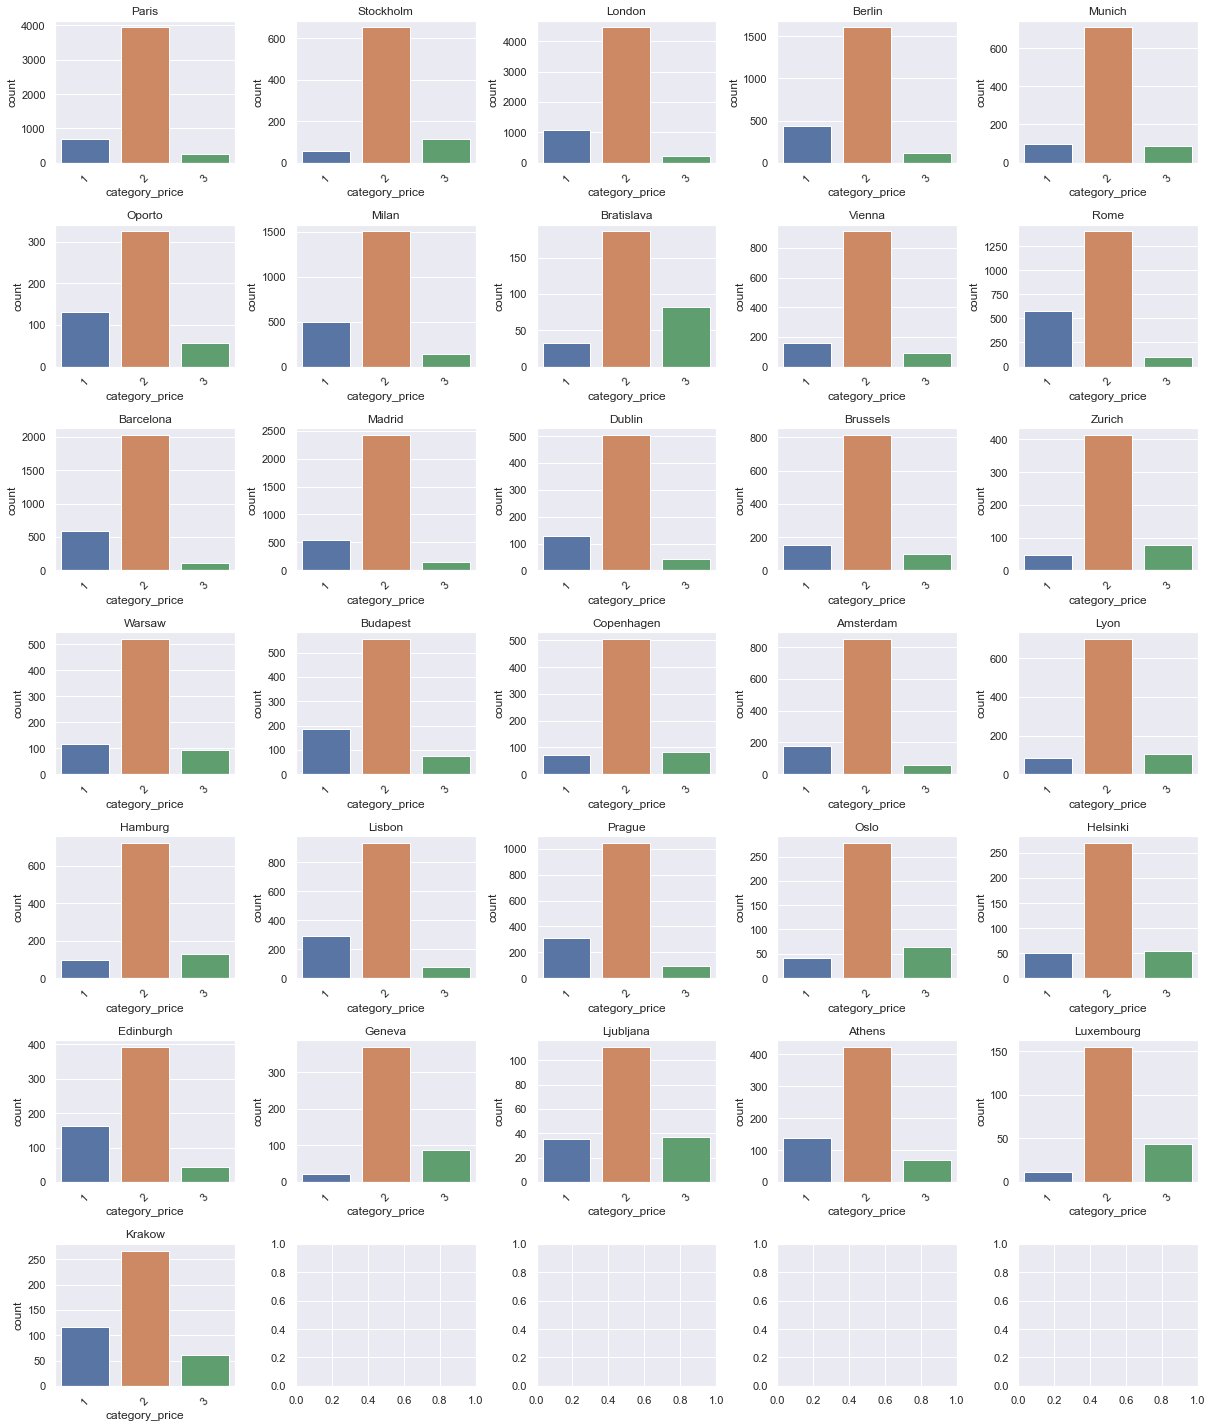

In [28]:
# Посмотрим распределение ценовых категорий по городам.
fig, axes = plt.subplots(nrows=7,ncols=5,figsize=(17,20))
i = 0
for c in list_city:
    df_city = df[df['city'] == c]
    plot = sns.countplot(x='category_price', data = df_city, ax=axes.flatten()[i])
    plot.set_title(c)
    plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
    plt.tight_layout()
    i = i + 1  

Таким образом видно, что распределение ресторанов по ценовым категориям во всех городах приблизительно одинаково. Преобладает средняя ценовая категория, затем идут рестораны с низкой ценой. Только в двух городах количество ресторанов с низкой и высокой ценой примерно совпадает - это Женева и Люксембург.

### 4) number_of_reviews - Количество отзывов

Количественный признак. Пропусков 2543 или 6 % от всех данных. 

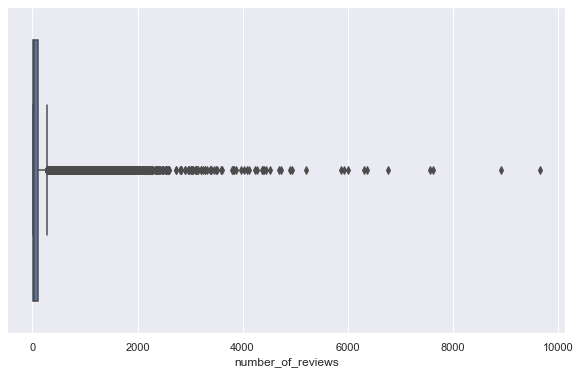

In [29]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.boxplot(df.number_of_reviews);

Видно, что есть выбросы. Отрицательных значений нет.

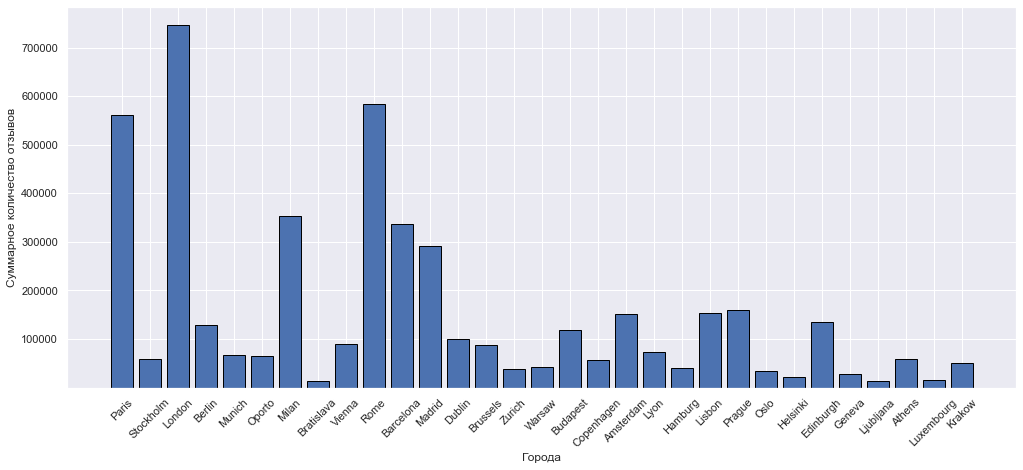

In [30]:
# Посмотрим общее число отзывов по городам
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    x = list()
    y = list()
    for city in list_city:
        x.append(city)
        y.append(df[df['city'] == city]['number_of_reviews'].sum())
    fig, ax = plt.subplots(1,1,figsize=(17,7))
    ax.bar(x,y,edgecolor = 'black')
    ax.set_ylim(bottom=3.5)
    ax.set_xticklabels(labels = x, rotation = 45)
    ax.set_xlabel('Города')
    ax.set_ylabel('Суммарное количество отзывов')
plt.show()

Видно, что больше всего отзывов оставлено по ресторанам Лондона, на втором месте идет Рим, на третьем - Париж.

In [26]:
# Посмотрим абс и относит величину пропущенных значений по каждому признаку
df.groupby('city').id_ta.count()
reviews_city_isnan = pd.DataFrame({'count': df[df.number_of_reviews.isna()].groupby('city').id_ta.count(),
                           'ratio': df[df.number_of_reviews.isna()].groupby('city').id_ta.count()\
                           /df.groupby('city').id_ta.count()}).query('count > 0').sort_values('count', ascending=False)
print('Распределение пропусков в количестве отзывов по городам:\n\n{}'
      .format(reviews_city_isnan))

Распределение пропусков в количестве отзывов по городам:

            count     ratio
city                       
London        349  0.060622
Paris         224  0.045742
Berlin        204  0.094664
Madrid        193  0.062098
Barcelona     187  0.068398
Prague        161  0.111573
Milan         103  0.048289
Vienna         99  0.084906
Lisbon         85  0.065385
Hamburg        76  0.080084
Warsaw         75  0.103164
Brussels       72  0.067925
Budapest       67  0.082108
Munich         65  0.072788
Stockholm      62  0.075610
Rome           59  0.028393
Amsterdam      50  0.046041
Bratislava     43  0.142857
Lyon           41  0.045964
Athens         39  0.062102
Copenhagen     36  0.054628
Geneva         35  0.072765
Oporto         35  0.068226
Dublin         34  0.050520
Zurich         33  0.061338
Krakow         28  0.063205
Helsinki       24  0.063830
Oslo           19  0.049351
Edinburgh      17  0.028523
Ljubljana      15  0.081967
Luxembourg     13  0.061905


In [27]:
# Заполню пропуски данных в признаке Количество отзывов медианным значением по ресторанам города:

# Рассчитаю медиану по каждому городу:
df_median = df[['city', 'number_of_reviews']].groupby(
    'city', as_index=False).number_of_reviews.median()

# Результаты расчета записываю в словарь:
dict_median_of_number = dict(
    zip(df_median.set_index('city').T, df_median.number_of_reviews))

# Заполняю пропуски значениями из словаря:
df.loc[(df.number_of_reviews.isna()), 'number_of_reviews'] = df.city.map(dict_median_of_number)

#df[(df.city == 'Luxembourg') & (df.number_of_reviews == 34.0)].shape[0]

Посмотрим на выбросы.

Применим метод межквартильного расстояния.

In [28]:
# Функция нахождения выбросов методом межквартильного расстояния:


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('[{l}, {u}]'.format(l=lower_bound, u=upper_bound))
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [29]:
# Вызываю функцию по нахождению выбросов методом межквартильного расстояния:
iqr_outliers = outliers_iqr(df.number_of_reviews)

print('\nКоличество значений за границами, рассчитанными методом межквартильного расстояния:',
      df.iloc[iqr_outliers].shape[0])

print('Количество "нормальных" значений:',
      df.shape[0]-df.iloc[iqr_outliers].shape[0])

[-134.0, 250.0]

Количество значений за границами, рассчитанными методом межквартильного расстояния: 4794
Количество "нормальных" значений: 35206


Метод межквартильного расстояния посчитал выбросами 4794 записей. Это слишком много.

In [30]:
# Функция по нахождению выбросов - модифицированный метод Z-score (использует медиану и медианное абсолютное отклонение)


def outliers_modified_z_score(ys):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    z_outliers = outliers_modified_z_score(df.number_of_reviews)

print('Модифицированный z-score посчитал выбросами {} записей.'.format(df.iloc[z_outliers].shape[0]))

Модифицированный z-score посчитал выбросами 6779 записей.


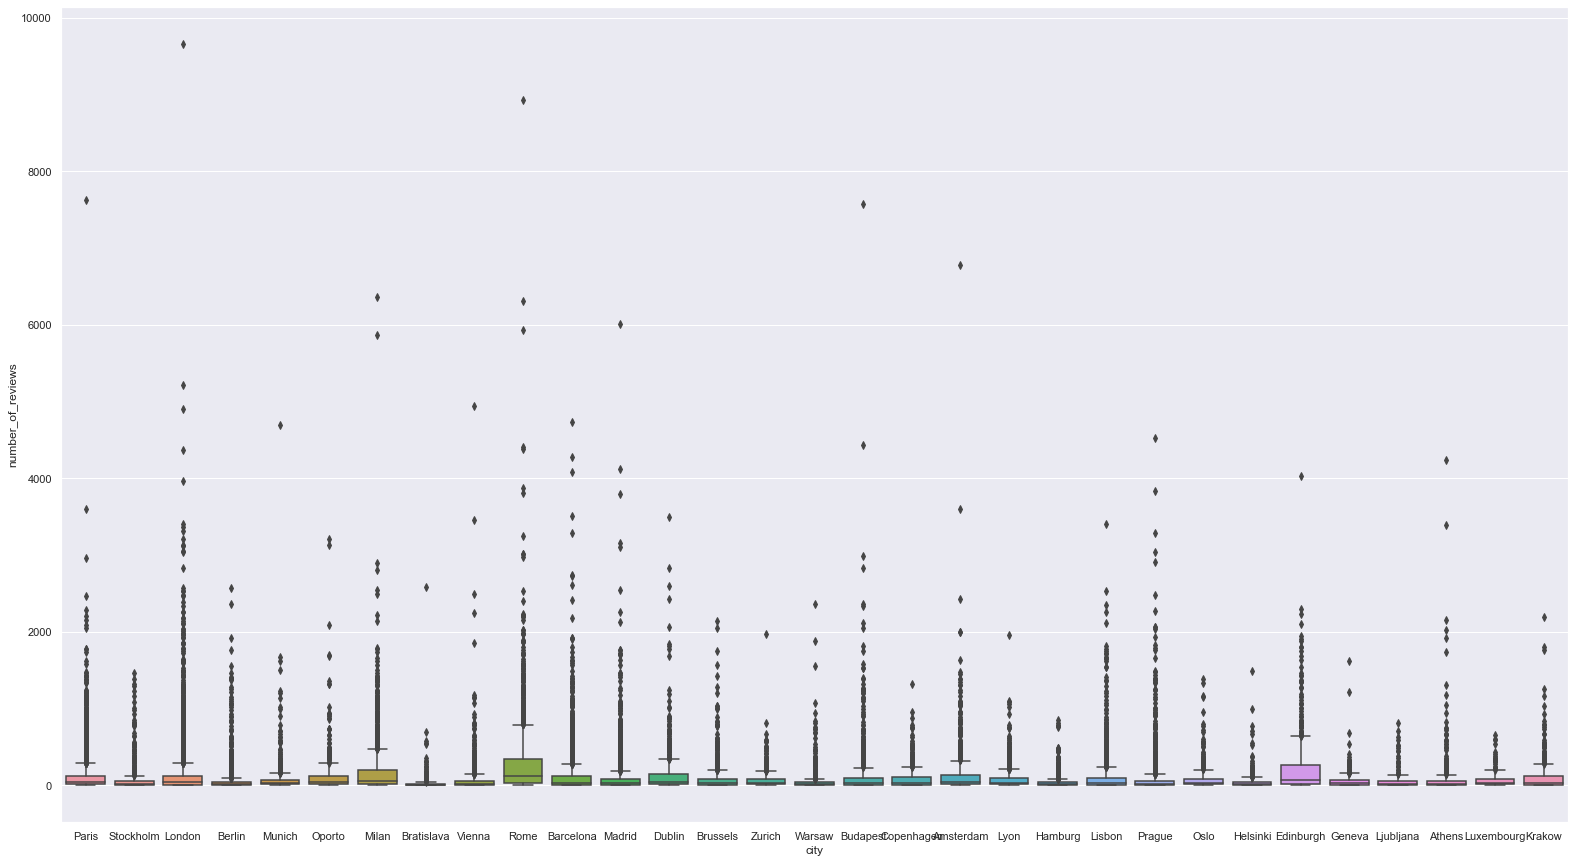

In [37]:
# Посмотрим на боксплоты в разрезе городов.

sns.set(rc={'figure.figsize': (27, 15)})
sns.boxplot(x='city', y='number_of_reviews',
            data=df.query("city in @list_city"));

Выбросы пока трогать не буду. Создам новый признак, в котором будет отметка по выбросам, выявленным методом межквартильного расстояния.

### New feature - outlier_number_of_reviews

In [32]:
upper = df.iloc[iqr_outliers].number_of_reviews.min()
df['outlier_number_of_reviews'] = df.number_of_reviews.apply(lambda x: 1 if x > upper else 0)

### New features
- number_of_reviews_in_city - количество отзывов о ресторанах в городе
- rest_number_of_reviews_in_city- какую долю имеет ресторан в общем количестве отзывов по городу

In [33]:
reviews_in_city = df.groupby(['city'])[
    'number_of_reviews'].sum().sort_values(ascending=False)

df['number_of_reviews_in_city'] = df['city'].apply(
    lambda x: reviews_in_city[x])

df['rest_number_of_reviews_in_city'] = df['ranking'] / df['number_of_reviews_in_city']

### 5) reviews: 2 последних отзыва и даты этих отзывов

Категориальный признак. Для дальнейшей работы данные необходимо преобразовать. Есть пустые значения, но в виде списка в строке ([]).

In [34]:
# Выясним сколько строк-пустых списков содержится в датасете
print('Пустых отзывов:',df[df.reviews.str.contains("\[\]", na=False)].reviews.value_counts())

Пустых отзывов: [[], []]    6471
Name: reviews, dtype: int64


In [35]:
# Пустые значения в виде строки со значением [[], []] сохраняю: 
df['reviews_isEmpty'] = df['reviews'].apply(lambda x: 1 if x=="[[], []]" else 0)

# Преообразовываю reviews из строки, в список:
df['reviews'] = df.reviews.str.replace(r'[\[\]]','')
df['reviews'] = df.reviews.str.replace(r'"', "'").apply(lambda x: x[1:-1].split(", '"))

###  New features - first, second, first_review_date, second_review_date, days_between_reviews

Добавляю новые признаки - 1-й отзыв, 2-й отзыв, дата 1-го отзыва, дата 2-го отзыва и количество дней между 1-м и 2-м отзывом:

In [36]:
df['first'] = df.reviews.apply(lambda x: str(x[0]) if len(x) >= 2 else '')
df['second'] = df.reviews.apply(lambda x: str(x[1]) if len(x) == 4 else '')

df['first_review_date'] = pd.to_datetime(df.reviews.apply(
    lambda x: x[2] if len(x) == 4 else x[1] if 2 <= len(x) < 4 else ''))
df['second_review_date'] = pd.to_datetime(
    df.reviews.apply(lambda x: x[3] if len(x) == 4 else x[2] if len(x) == 3 else ''))

df['days_between_reviews'] = abs(
    (df.first_review_date - df.second_review_date).dt.days)

# В признаке days_between_reviews заполню пропуски нулем:
df.days_between_reviews.fillna(0, inplace=True)
# df.head()

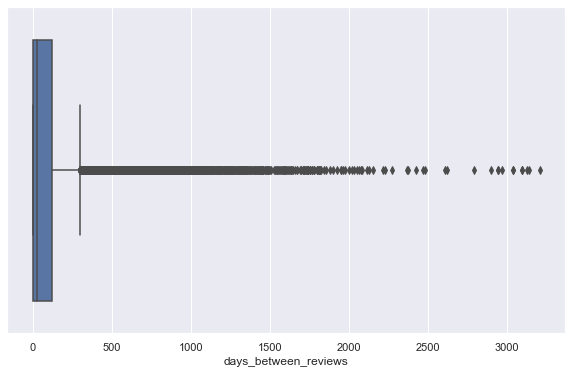

In [43]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.boxplot(df.days_between_reviews.dropna());

Видно, что в датах отзывов есть слишком большие разницы. Посмотрим, с чем они могут быть связаны.

In [44]:
print(df.loc[(df.days_between_reviews > 2200), ['first', 'second',
                                                'first_review_date', 'second_review_date']].shape[0])
df.loc[(df.days_between_reviews > 2200), ['number_of_reviews', 'first',
                                          'second', 'first_review_date', 'second_review_date', 'id_ta']]

22


,number_of_reviews,first,second,first_review_date,second_review_date,id_ta
2028,2.0,Great local curry',Love their black bean and spinach daal',2016-10-27,2008-07-01,d788235
3324,11.0,A little Korean delight in Paris',top freshness take away',2017-08-08,2011-02-15,d778850
3380,26.0,Happy hour drinks and meal',Very good',2016-08-31,2008-09-25,d1069475
6958,8.0,Lovely outside setting with good service',Pricy but good. Interesting recipes with a...',2016-08-23,2008-05-02,d696012
7990,21.0,Incredible buffet!',"Used to be great, but still good under new...'",2016-10-02,2007-12-22,d805046
8356,5.0,Very pleasant staff',"Stylish Café&Pub, i like...'",2016-06-28,2008-01-06,d794693
10997,62.0,"Crowded, don't go there when they host wed...'",Most surprising Karaoke/chineese restauran...',2016-10-26,2008-03-25,d805286
11140,2.0,Probably the best Italian restaurant I've...',Very good Italian restaurant.',2015-12-28,2007-11-14,d743871
12559,11.0,Dinner with my wife',simply the best !!!!',2016-06-27,2008-06-06,d1019785
14101,3.0,4 days in Krakow',"I love U Pollera. Same staff, same list wi...'",2016-07-25,2010-05-07,d1045657


In [2]:
df.loc[(df.days_between_reviews==df.days_between_reviews.max()),['first_review_date', 'second_review_date']]

NameError: name 'df' is not defined

Пока эти данные не трогаю, так как не понятно, что с ними делать. Сайт функционирует почти 20 лет и удалять отзывы 2007-2009 годов будет неправильно. Другой вопрос - почему есть такие большие промежутки между отзывами?

###  New feature - last_review_year_value

Добавляю новый признак -проранжирую отзывы по годам:
- 0 - отзывы, оставленные до 2014 года и пустые значения;
- 1 - отзывы, оставленные в 2014 году;
- 2 - в 2015 году;
- 3 - 2016;
- 4 - 2017;
- 5 - 2018

In [37]:
# Составляю словарь значений рангов по годам отзывов:
dict_val = {2013: 0, 2014: 1, 2015: 2, 2016: 3, 2017: 4, 2018: 5}

# В новый столбец last_review записываю максимальную из дат двух отзывов:
df['last_review'] = df[['first_review_date', 'second_review_date']].max(axis=1)

# Заполняю новый признак last_review_value значениями рангов в зависимости от года последнего отзыва
for i, j in dict_val.items():
    if i == 2013:
        df.loc[(df.last_review.dt.year <= i), 'last_review_year_value'] = 0
    else:
        df.loc[(df.last_review.dt.year == i), 'last_review_year_value'] = j

# Пропуски заполню нулем:
df.last_review_year_value.fillna(0, inplace=True)

df[['last_review', 'last_review_year_value']].head()

,last_review,last_review_year_value
0,2017-12-31,4.0
1,2017-07-06,4.0
2,2018-01-08,5.0
3,NaT,0.0
4,2017-11-18,4.0


In [38]:
# Создам новый столбец - Количество отзывов в столбце reviews:
df['len_reviews'] = df['reviews'].apply(lambda x: 2 if len(x)==4 else 1 if 1<len(x)<4 else 0)


### New feature - day_to_now

Создам новый признак - как давно был сделан самый последний отзыв (в днях).

In [39]:
# Функция по заполнению разницы в днях между текущей датой и датой последнего отзыва:
def time_to_now(row):
    if row['last_review'] == []:
        return None
    return datetime.now() - pd.to_datetime(row['last_review'])


df['day_to_now'] = df.apply(time_to_now, axis = 1).dt.days

# Пропуски заполню нулем:
df.day_to_now.fillna(0, inplace=True)

In [40]:
# Удалю все поля с датами:
cols = df.select_dtypes(include='datetime').columns.tolist()
df = df.drop(cols, axis=1)


### 6) ranking - Ранг ресторана относительно других ресторанов в этом городе

Количественный признак. Пропусков нет.

Посмотрим распределение признака:

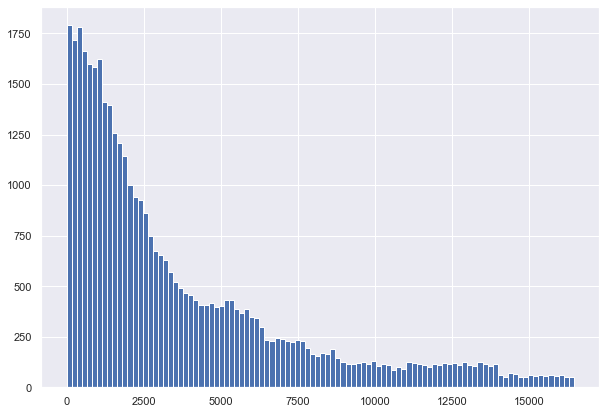

In [50]:
plt.rcParams['figure.figsize'] = (10,7)
df['ranking'].hist(bins=100);

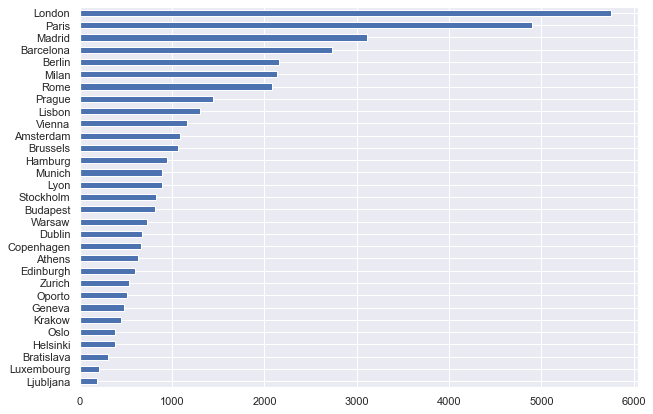

In [51]:
# Посмотрим распределение по городам:
df['city'].value_counts(ascending=True).plot(kind='barh');

 Посмотрим, как изменится распределение в большом городе:

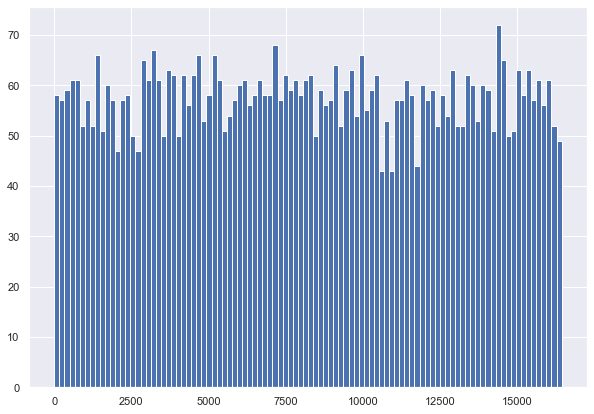

In [52]:
df['ranking'][df['city'] =='London'].hist(bins=100);

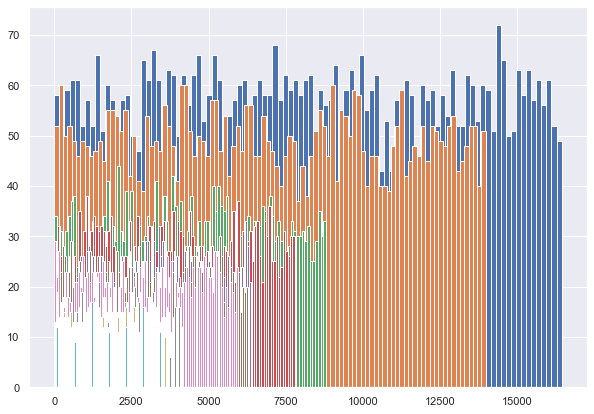

In [53]:
# посмотрим на топ 10 городов
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show();

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [41]:
# Нормирование признака ranking по городам:
mean_ranking_city = df.groupby('city').ranking.mean()
std_ranking_city = df.groupby('city').ranking.std()
df['ranking_city_norm'] = (df.ranking - df.city.map(mean_ranking_city))/(df.city.map(std_ranking_city))

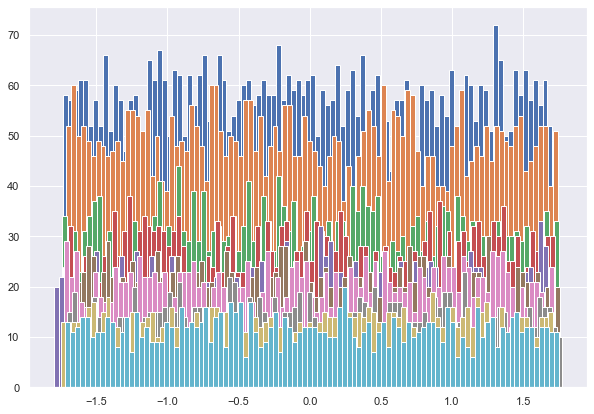

In [55]:
# посмотрим что получилось на топ 10 городов
for x in (df['city'].value_counts())[:10].index:
    df['ranking_city_norm'][df['city'] == x].hist(bins=100)
plt.show();

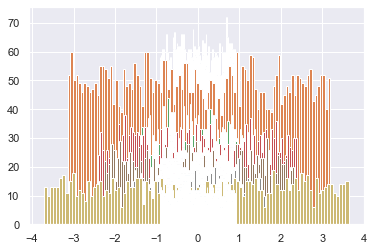

In [42]:
# Нормализация ranking по населению
df['norm_ranking_population'] = (
    df.ranking - df.city.map(mean_ranking_city)) / df.city_population

for x in (df['city'].value_counts())[0:10].index:
    df['norm_ranking_population'][df.city == x].hist(bins=100)
plt.show();

### id_ta — идентификатор ресторана в базе данных TripAdvisor

Чаще всего id присваивается при первоначальном внесении данных, отсюда можно судить, как давно ресторан сотрудничает с TripAdvisor.

Уберу символ 'd' вначале, чтобы осталось число:

In [43]:
df['id_ta'] = df['id_ta'].apply(lambda x: int(x[1:]))

### Посмотрим распределение целевой переменной

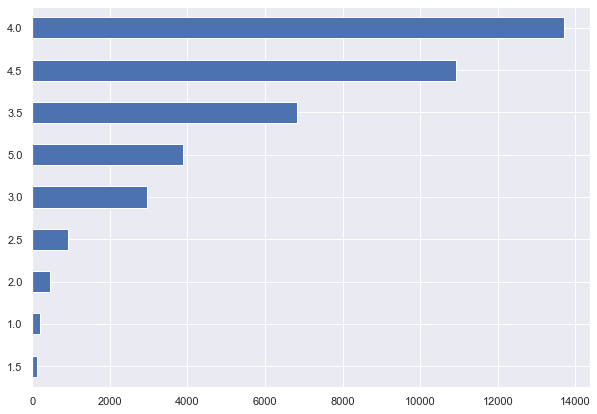

In [70]:
df['rating'].value_counts(ascending=True).plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака

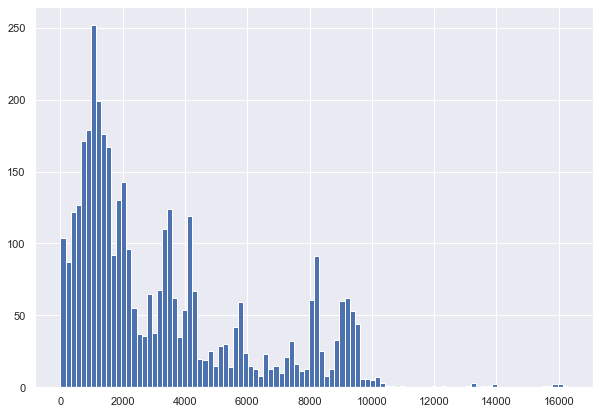

In [71]:
df['ranking'][df['rating'] == 5].hist(bins=100);

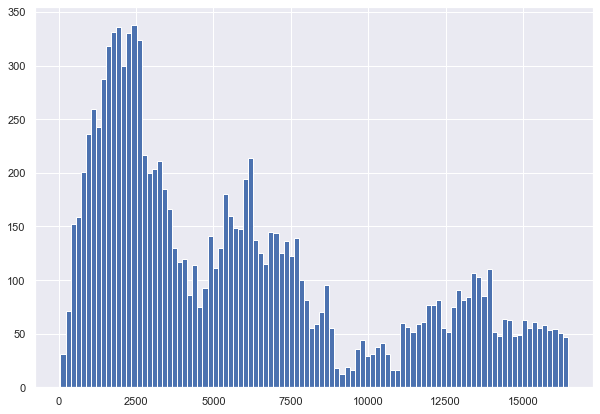

In [72]:
df['ranking'][df['rating'] < 4].hist(bins=100);

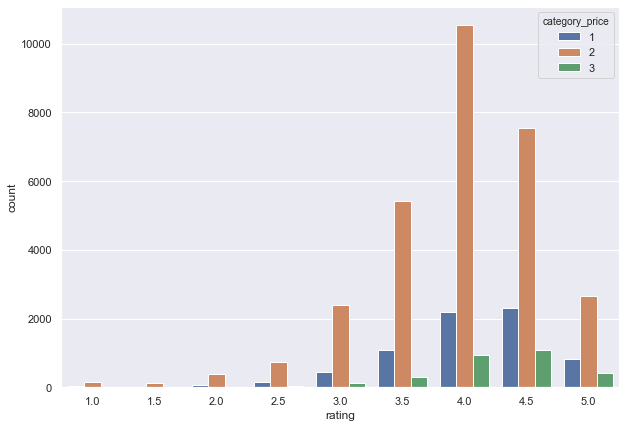

In [73]:
sns.countplot(x='rating', data = df, hue = 'category_price');

### Посмотрим корреляцию признаков

<AxesSubplot:>

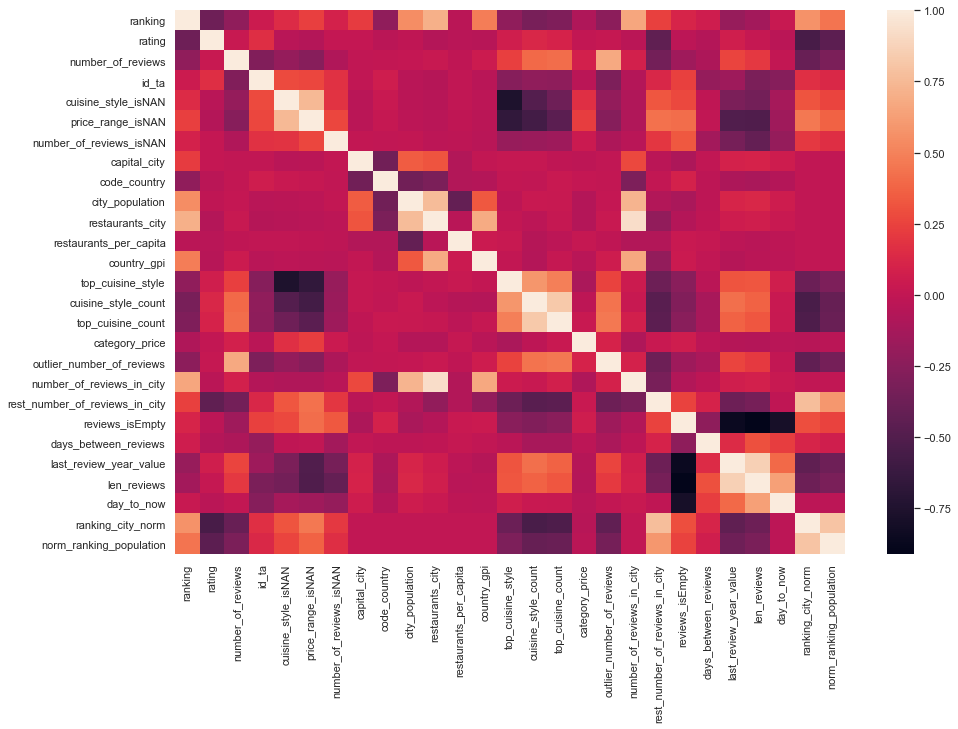

In [44]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(),)

In [45]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,ranking,rating,number_of_reviews,id_ta,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,capital_city,code_country,city_population,restaurants_city,restaurants_per_capita,country_gpi,top_cuisine_style,cuisine_style_count,top_cuisine_count,category_price,outlier_number_of_reviews,number_of_reviews_in_city,rest_number_of_reviews_in_city,reviews_isEmpty,days_between_reviews,last_review_year_value,len_reviews,day_to_now,ranking_city_norm,norm_ranking_population
ranking,1.00,-0.37,-0.22,0.05,0.15,0.23,0.09,0.22,-0.22,0.55,0.71,-0.03,0.48,-0.22,-0.32,-0.29,-0.08,-0.24,0.66,0.24,0.11,0.07,-0.19,-0.14,0.02,0.57,0.45
rating,-0.37,1.00,0.03,0.16,-0.04,-0.06,0.01,0.02,-0.03,-0.01,-0.06,-0.04,-0.05,0.07,0.12,0.10,0.01,0.02,-0.03,-0.43,-0.02,-0.07,0.07,0.02,-0.03,-0.55,-0.45
number_of_reviews,-0.22,0.03,1.00,-0.29,-0.20,-0.26,-0.08,0.00,0.00,0.01,0.03,-0.01,0.05,0.24,0.40,0.41,0.08,0.67,0.09,-0.35,-0.15,-0.09,0.26,0.20,0.01,-0.40,-0.31
id_ta,0.05,0.16,-0.29,1.00,0.28,0.27,0.18,-0.00,0.07,-0.04,-0.06,-0.00,-0.04,-0.26,-0.22,-0.23,-0.03,-0.30,-0.06,0.12,0.25,-0.19,-0.16,-0.31,-0.26,0.17,0.13
cuisine_style_isNAN,0.15,-0.04,-0.20,0.28,1.00,0.75,0.19,-0.04,0.03,-0.03,-0.05,-0.00,-0.03,-0.76,-0.49,-0.37,0.17,-0.20,-0.08,0.32,0.27,-0.01,-0.31,-0.35,-0.12,0.32,0.26
price_range_isNAN,0.23,-0.06,-0.26,0.27,0.75,1.00,0.27,-0.03,0.02,-0.03,-0.04,-0.01,-0.03,-0.66,-0.57,-0.46,0.22,-0.26,-0.08,0.43,0.41,-0.01,-0.50,-0.51,-0.15,0.46,0.37
number_of_reviews_isNAN,0.09,0.01,-0.08,0.18,0.19,0.27,1.00,0.01,-0.00,0.00,-0.02,-0.02,-0.04,-0.19,-0.18,-0.16,0.04,-0.10,-0.04,0.20,0.33,-0.13,-0.33,-0.41,-0.20,0.21,0.16
capital_city,0.22,0.02,0.00,-0.00,-0.04,-0.03,0.01,1.00,-0.35,0.35,0.32,-0.07,0.00,0.02,0.02,-0.01,-0.02,-0.01,0.27,-0.03,-0.09,-0.00,0.09,0.10,0.06,0.00,0.00
code_country,-0.22,-0.03,0.00,0.07,0.03,0.02,-0.00,-0.35,1.00,-0.35,-0.31,-0.07,-0.06,0.01,-0.01,0.04,0.01,0.01,-0.30,0.00,0.10,-0.02,-0.09,-0.11,-0.06,-0.00,-0.00
city_population,0.55,-0.01,0.01,-0.04,-0.03,-0.03,0.00,0.35,-0.35,1.00,0.77,-0.42,0.34,-0.02,0.04,0.03,-0.06,0.01,0.72,-0.07,-0.11,-0.02,0.11,0.13,0.06,0.00,-0.00


In [44]:
print('Ранг матрицы - {}, det(c_mat) = {}'.format(np.linalg.matrix_rank(corr), np.linalg.det(corr)))
corr.shape

Ранг матрицы - 27, det(c_mat) = 1.084878615118972e-10


(27, 27)

Ранг матрицы корреляций максимальный, определитель близок к нулю, матрица плохо обусловлена, признаки мультиколлинеарны. Мы видим, что сильно скоррелированы признаки top_cuisine_style и cuisine_style_isNAN, price_range_isNAN и cuisine_style_isNAN; reviews_isEmpty c last_review_year_value, day_to_now; city_population с restaurants_city. Попробуем убрать сильно коррелирующие признаки(межфакторный коэфф-т корреляции > 0.7).

In [46]:
# Добавлю новые признаки:
df['log_ranking_city_norm'] = np.log(df.ranking_city_norm[df.ranking_city_norm > 0])
df['sqrt_ranking_city_norm'] = np.sqrt(df.ranking_city_norm[df.ranking_city_norm > 0])
df['log_rest_number_of_reviews_in_city'] = np.log(df.rest_number_of_reviews_in_city[df.rest_number_of_reviews_in_city > 0])
df['sqrt_rest_number_of_reviews_in_city'] = np.sqrt(df.rest_number_of_reviews_in_city[df.rest_number_of_reviews_in_city > 0])

In [48]:
corr = df.drop(['cuisine_style_isNAN', 'reviews_isEmpty', 'number_of_reviews_in_city', 'city_population', 
                'top_cuisine_count', 'len_reviews', 'rest_number_of_reviews_in_city', 'ranking_city_norm', 
                'log_ranking_city_norm', 'log_rest_number_of_reviews_in_city'], axis=1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())
# 'top_cuisine_count', 'rest_number_of_reviews_in_city', 

,ranking,rating,number_of_reviews,id_ta,price_range_isNAN,number_of_reviews_isNAN,capital_city,code_country,restaurants_city,restaurants_per_capita,country_gpi,top_cuisine_style,cuisine_style_count,category_price,outlier_number_of_reviews,days_between_reviews,last_review_year_value,day_to_now,norm_ranking_population,sqrt_ranking_city_norm,sqrt_rest_number_of_reviews_in_city
ranking,1.00,-0.37,-0.22,0.05,0.23,0.09,0.22,-0.22,0.71,-0.03,0.48,-0.22,-0.32,-0.08,-0.24,0.07,-0.19,0.02,0.45,0.26,0.33
rating,-0.37,1.00,0.03,0.16,-0.06,0.01,0.02,-0.03,-0.06,-0.04,-0.05,0.07,0.12,0.01,0.02,-0.07,0.07,-0.03,-0.45,-0.64,-0.43
number_of_reviews,-0.22,0.03,1.00,-0.29,-0.26,-0.08,0.00,0.00,0.03,-0.01,0.05,0.24,0.40,0.08,0.67,-0.09,0.26,0.01,-0.31,-0.00,-0.46
id_ta,0.05,0.16,-0.29,1.00,0.27,0.18,-0.00,0.07,-0.06,-0.00,-0.04,-0.26,-0.22,-0.03,-0.30,-0.19,-0.16,-0.26,0.13,-0.06,0.16
price_range_isNAN,0.23,-0.06,-0.26,0.27,1.00,0.27,-0.03,0.02,-0.04,-0.01,-0.03,-0.66,-0.57,0.22,-0.26,-0.01,-0.50,-0.15,0.37,0.05,0.46
number_of_reviews_isNAN,0.09,0.01,-0.08,0.18,0.27,1.00,0.01,-0.00,-0.02,-0.02,-0.04,-0.19,-0.18,0.04,-0.10,-0.13,-0.33,-0.20,0.16,-0.02,0.20
capital_city,0.22,0.02,0.00,-0.00,-0.03,0.01,1.00,-0.35,0.32,-0.07,0.00,0.02,0.02,-0.02,-0.01,-0.00,0.09,0.06,0.00,-0.01,-0.02
code_country,-0.22,-0.03,0.00,0.07,0.02,-0.00,-0.35,1.00,-0.31,-0.07,-0.06,0.01,-0.01,0.01,0.01,-0.02,-0.09,-0.06,-0.00,-0.00,0.00
restaurants_city,0.71,-0.06,0.03,-0.06,-0.04,-0.02,0.32,-0.31,1.00,-0.04,0.68,0.01,-0.02,-0.06,0.03,-0.01,0.06,0.03,0.00,0.01,-0.17
restaurants_per_capita,-0.03,-0.04,-0.01,-0.00,-0.01,-0.02,-0.07,-0.07,-0.04,1.00,0.04,0.02,-0.06,0.02,-0.01,0.02,-0.03,-0.02,-0.00,-0.00,-0.04


In [49]:
print('Ранг матрицы - {}, det(c_mat) = {}'.format(np.linalg.matrix_rank(corr), np.linalg.det(corr)))
corr.shape

Ранг матрицы - 21, det(c_mat) = 0.00024950118094077187


(21, 21)

Ранг матрицы корреляций максимальный и определитель стал чуть больше. Оставлю квадратичные признаки, прологарифмированные признаки удалю.

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [36]:
# на всякий случай, заново подгружаем данные
DATA_DIR = 'C:/Users/ondar/SF/SkillFactory/Unit_3_ModelML/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Переименуем столбцы датасета для удобства работы
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [15]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating']

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [37]:
# Если надо, то снова определим все словари и списки
list_city = list(df['city'].unique())
capitals = ['Mariehamn', 'Tirana', 'Andorra la Vella', 'Vienna',
            'Minsk', 'Brussels', 'Sarajevo', 'Sofia',
            'Zagreb', 'Nicosia', 'Prague', 'Copenhagen',
            'Tallinn', 'Tórshavn', 'Helsinki', 'Paris',
            'Berlin', 'Gibraltar', 'Athens', 'St. Peter Port',
            'Budapest', 'Reykjavik', 'Dublin', 'Douglas',
            'Rome', 'Saint Helier', 'Pristina', 'Riga',
            'Vaduz', 'Vilnius', 'Luxembourg', 'Skopje',
            'Valletta', 'Chișinău', 'Monaco', 'Podgorica',
            'Amsterdam', 'Oslo', 'Warsaw', 'Lisbon',
            'Bucharest', 'Moscow', 'City of San Marino', 'Belgrade',
            'Bratislava', 'Ljubljana', 'Madrid', 'Longyearbyen',
            'Stockholm', 'Bern', 'Kiev', 'London', 'Vatican City']

dict_countries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czechia', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Netherlands', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Pr_Luxembourg', 'Ljubljana' : 'Slovenia'}

dict_city_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}

restaurants_city = df['city'].value_counts(ascending=False)

dict_gpi = {'Pr_Luxembourg': 1.078, 'Portugal': 1.247, 'Austria': 1.275, 'Denmark': 1.283, 'Czechia': 1.337, 
                 'Switzerland': 1.366, 'Slovenia': 1.369, 'Ireland': 1.375, 'Finland': 1.404, 'Sweden': 1.479, 
                 'Germany': 1.494, 'Belgium': 1.496, 'Norway': 1.496, 'Netherlands': 1.528, 'Romania': 1.541, 
                 'Slovakia': 1.568, 'Poland': 1.657, 'Italy': 1.69, 'Spain': 1.712, 'England': 1.77, 
                 'Scotland': 1.77, 'Greece': 1.877, 'France': 1.93}

dict_price = {'$':1,'$$ - $$$':2,'$$$$':3}

dict_val = {2013: 0, 2014: 1, 2015: 2, 2016: 3, 2017: 4, 2018: 5}

In [38]:
# ну и функции отдельно
def is_top_cuisines(val):
    top = []
    if val=='':
        return ['Other']
    else:
        top = [i for i in val if i in top_cuisines]
    if len(top):
        return top
    else:
        return ['Other']
    

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]


def time_to_now(row):
    if row['last_review'] == []:
        return None
    return datetime.now() - pd.to_datetime(row['last_review'])

In [39]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

    df_output['cuisine_style_isNAN'] = pd.isna(df_output['cuisine_style']).astype('uint8')
    df_output['price_range_isNAN'] = pd.isna(df_output['price_range']).astype('uint8')
    df_output['number_of_reviews_isNAN'] = pd.isna(df_output['number_of_reviews']).astype('uint8')
    df_output.reviews.fillna("[[], []]", inplace=True)
    df_output['reviews_isEmpty'] = df['reviews'].apply(lambda x: 1 if x=="[[], []]" else 0)    
    
    df_output['capital_city'] = df_output.city.apply(lambda x: 1 if x in capitals else 0)
    df_output['country'] = df_output.city.map(dict_countries)
    df_output['city_population'] = df_output.city.map(dict_city_population)
    
    le = LabelEncoder()
    le.fit(df_output['country'])
    df_output['code_country'] = le.transform(df_output['country'])
    
    df_output['restaurants_city'] = df_output['city'].apply(lambda x: restaurants_city[x])
    df_output['restaurants_per_capita'] = df_output['restaurants_city'] / (df_output['city_population'])
    df_output['country_gpi'] = df_output.country.map(dict_gpi)

    df_output['cuisine_style'] = df_output.cuisine_style.apply(lambda x: ast.literal_eval(x) if pd.isnull(x)==False else '')

    cuisine = [i for i in df_output.cuisine_style.explode() if i!='']

    counter_cuisine = pd.DataFrame(Counter(cuisine).most_common(), columns=['cuisine_style', 'count_style'])
    top_cuisines_count = int(np.percentile(counter_cuisine.count_style.tolist(), 90))
    
    top_cuisines = counter_cuisine[counter_cuisine.count_style >= top_cuisines_count].cuisine_style.tolist()
    def is_top_cuisines(val):
        top = []
        if val=='':
            return ['Other']
        else:
            top = [i for i in val if i in top_cuisines]
        if len(top):
            return top
        else:
            return ['Other']
    df_output['is_top_cuisines'] = df_output.cuisine_style.apply(is_top_cuisines)
    df_output['cuisine_style'] = df_output.cuisine_style.apply(lambda x: ['Other'] if x=='' else x)
    df_output['top_cuisine_style'] = df_output.apply(lambda x: 1 if len([i for i in x.cuisine_style if i in top_cuisines]) != 0 \
                                       else 0, axis=1)
    df_output['cuisine_style_count'] = df_output.cuisine_style.apply(lambda x: len(x))
    df_output['top_cuisine_count'] = df_output.is_top_cuisines.apply(lambda x: 0 if x=='Other' else len(x))
    
    list_rest = df_output[df_output.price_range.isna()]['restaurant_id'].tolist()
    count_price_rest = df_output[['restaurant_id', 'price_range', 'id_ta']].query('restaurant_id in @list_rest')\
                        .groupby(['restaurant_id', 'price_range'], as_index=False).count()
    mode_price_rest = count_price_rest.groupby('restaurant_id', as_index=False)[['price_range']].max()
    dict_price_rest = dict(zip(mode_price_rest.set_index('restaurant_id').T, mode_price_rest.price_range))
    
    df_output.loc[(df_output.price_range.isna()) & (df_output.restaurant_id.isin(dict_price_rest.keys())),
           'price_range'] = df_output.restaurant_id.map(dict_price_rest)
    
    df_output.price_range.fillna(df_output.price_range.mode()[0], inplace=True)
    
    df_output['category_price'] = df_output.price_range.map(dict_price)
    
    df_output_median = df_output[['city', 'number_of_reviews']].groupby('city', as_index=False).number_of_reviews.median()
    dict_median_of_number = dict(zip(df_output_median.set_index('city').T, df_output_median.number_of_reviews))
    
    df_output.loc[(df_output.number_of_reviews.isna()), 'number_of_reviews'] = df_output.city.map(dict_median_of_number)
    

    iqr_outliers = outliers_iqr(df_output.number_of_reviews)

    upper = df_output.iloc[iqr_outliers].number_of_reviews.min()
    df_output['outlier_number_of_reviews'] = df_output.number_of_reviews.apply(lambda x: 1 if x > upper else 0)

    reviews_in_city = df_output.groupby(['city'])['number_of_reviews'].sum().sort_values(ascending=False)
    df_output['number_of_reviews_in_city'] = df_output['city'].apply(lambda x: reviews_in_city[x])
    df_output['rest_number_of_reviews_in_city'] = df_output['ranking'] / df_output['number_of_reviews_in_city']
    
    df_output['reviews'] = df_output.reviews.str.replace(r'[\[\]]','')
    df_output['reviews'] = df_output.reviews.str.replace(r'"', "'").apply(lambda x: x[1:-1].split(", '"))
    df_output['first'] = df_output.reviews.apply(lambda x: str(x[0]) if len(x) >= 2 else '')
    df_output['second'] = df_output.reviews.apply(lambda x: str(x[1]) if len(x) == 4 else '')
    df_output['first_review_date'] = pd.to_datetime(df_output.reviews.apply(
        lambda x: x[2] if len(x) == 4 else x[1] if 2 <= len(x) < 4 else ''))
    df_output['second_review_date'] = pd.to_datetime(df_output.reviews.apply(
        lambda x: x[3] if len(x) == 4 else x[2] if len(x) == 3 else ''))
    df_output['days_between_reviews'] = abs((df_output.first_review_date - df_output.second_review_date).dt.days)
    
    df_output.days_between_reviews.fillna(0, inplace=True)
    
    df_output['last_review'] = df_output[['first_review_date', 'second_review_date']].max(axis=1)
    for i, j in dict_val.items():
        if i == 2013:
            df_output.loc[(df_output.last_review.dt.year <= i), 'last_review_year_value'] = 0
        else:
            df_output.loc[(df_output.last_review.dt.year == i), 'last_review_year_value'] = j
    
    df_output.last_review_year_value.fillna(0, inplace=True)
    df_output['day_to_now'] = df_output.apply(time_to_now, axis = 1).dt.days
    
    df_output.day_to_now.fillna(0, inplace=True)
    
    mean_ranking_city = df_output.groupby('city').ranking.mean()
    std_ranking_city = df_output.groupby('city').ranking.std()
    df_output['mean_ranking_city'] = df_output.city.map(mean_ranking_city)
    df_output['ranking_city_norm'] = (df_output.ranking - df_output.mean_ranking_city)/(df_output.city.map(std_ranking_city))
    df_output['norm_ranking_population'] = (df_output.ranking - df_output.mean_ranking_city) / df_output.city_population
    df_output['norm_ranking'] = (df_output.ranking - df_output.mean_ranking_city) / df_output.restaurants_city
    ranking_by_city_max = df_output.groupby('city').ranking.max()
    df_output['ranking_by_city_max'] = df_output.city.map(ranking_by_city_max)
    df_output['norm_ranking_max'] = (df_output.ranking - df_output.mean_ranking_city) / df_output.ranking_by_city_max
    
    df_output['sqrt_ranking_city_norm'] = np.sqrt(df_output.ranking_city_norm[df_output.ranking_city_norm > 0])
    df_output['sqrt_rest_number_reviews_city'] = np.sqrt(df_output.rest_number_of_reviews_in_city[df_output.rest_number_of_reviews_in_city > 0])
    df_output['sqrt_number_of_reviews'] = np.sqrt(df_output.number_of_reviews[df_output.number_of_reviews > 0])
    df_output['sqrt_norm_ranking'] = np.sqrt(df_output.norm_ranking[df_output.norm_ranking > 0])
    df_output['sqrt_ranking_by_city_max'] = np.sqrt(df_output.ranking_by_city_max[df_output.ranking_by_city_max > 0])
    df_output['sqrt_norm_ranking_max'] = np.sqrt(df_output.norm_ranking_max[df_output.norm_ranking_max > 0])
    
    df_output['id_ta'] = df_output['id_ta'].apply(lambda x: int(x[1:]))
    
    for i  in list(df_output.columns):
        if i not in ['rating','sample']:
            if len(df_output[df_output[i].isna()]) < len(df_output):
                df_output[i] = df_output[i].fillna(0)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. 
    df_output_dum_cuisines = pd.get_dummies(df_output['is_top_cuisines'].apply(pd.Series).stack()).sum(level=0)
    df_output_dum_city = pd.get_dummies(df_output['city'])
    df_output_dum_country = pd.get_dummies(df_output['country'])
#    df_output_dum_price_range = pd.get_dummies(df_output['price_range']) 

    df_output = pd.concat([df_output, df_output_dum_cuisines], axis=1)
    df_output = pd.concat([df_output, df_output_dum_city], axis=1)
    df_output = pd.concat([df_output, df_output_dum_country], axis=1)
#    df_output = pd.concat([df_output, df_output_dum_price_range], axis=1)

    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    cols = df_output.select_dtypes(include=['O', 'datetime']).columns.tolist()
    df_output = df_output.drop(cols, axis=1)
    
    cols_dop = ['cuisine_style_isNAN', 'reviews_isEmpty', 'number_of_reviews_in_city', 'city_population', 
                'top_cuisine_count', 'norm_ranking', 'rest_number_of_reviews_in_city', 'ranking_city_norm', 
                'ranking_by_city_max', 'norm_ranking_max']
    df_output = df_output.drop(cols_dop, axis=1)
    
    return df_output

#### Запускаем и проверяем что получилось

In [40]:
df_preproc = preproc_data(df)
df_preproc.sample(10)

,ranking,number_of_reviews,id_ta,sample,rating,price_range_isNAN,number_of_reviews_isNAN,capital_city,code_country,restaurants_city,restaurants_per_capita,country_gpi,top_cuisine_style,cuisine_style_count,category_price,outlier_number_of_reviews,days_between_reviews,last_review_year_value,day_to_now,mean_ranking_city,norm_ranking_population,sqrt_ranking_city_norm,sqrt_rest_number_reviews_city,sqrt_number_of_reviews,sqrt_norm_ranking,sqrt_ranking_by_city_max,sqrt_norm_ranking_max,Asian,Bar,Cafe,European,French,Gluten Free Options,Italian,Mediterranean,Other,Pizza,Pub,Spanish,Vegan Options,Vegetarian Friendly,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Czechia,Denmark,England,Finland,France,Germany,Greece,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Pr_Luxembourg,Romania,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland
30114,2135.0,21.0,4829347,1,3.5,0,0,0,6,1126,2.225296,1.930,0,1,2,0,0.0,1.0,2157.0,1303.902309,1.642486,1.048141,0.149591,4.582576,0.859126,51.633323,0.558336,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23050,647.0,220.0,968850,1,3.5,0,0,1,2,1816,1.388379,1.337,1,4,2,0,29.0,4.0,982.0,2086.979626,-1.100902,0.000000,0.056338,14.832397,0.000000,64.714759,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24514,1762.0,48.0,4768894,1,4.0,0,0,1,2,1816,1.388379,1.337,1,3,2,0,40.0,4.0,985.0,2086.979626,-0.248455,0.000000,0.092972,6.928203,0.000000,64.714759,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33885,14540.0,33.0,2169622,1,2.0,1,0,1,4,7193,0.807476,1.770,1,3,2,0,512.0,4.0,1137.0,8169.707354,0.715120,1.161252,0.123720,5.744563,0.941076,128.234161,0.622409,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33746,2170.0,27.0,4735913,1,4.0,0,0,1,14,1647,3.254941,1.247,1,4,2,0,664.0,4.0,1282.0,1867.330298,0.598161,0.531690,0.104219,5.196152,0.428684,60.967204,0.285357,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
35997,10808.0,37.0,850061,1,3.5,0,0,1,4,7193,0.807476,1.770,0,2,1,0,223.0,4.0,1017.0,8169.707354,0.296171,0.747323,0.106667,6.082763,0.605629,128.234161,0.400551,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39834,751.0,200.0,6632958,1,4.0,0,0,1,14,1647,3.254941,1.247,1,3,2,0,163.0,5.0,938.0,1867.330298,-2.206186,0.000000,0.061311,14.142136,0.000000,60.967204,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4077,2383.0,86.0,4590434,0,0.0,0,0,1,20,3813,1.183059,1.712,1,1,2,0,113.0,4.0,1116.0,4388.516391,-0.622251,0.000000,0.080955,9.273618,0.000000,93.856273,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
14555,1155.0,485.0,5027428,1,4.0,0,0,0,10,2694,1.972182,1.690,1,6,2,1,152.0,4.0,1076.0,3106.027840,-1.428278,0.000000,0.051381,22.022716,0.000000,79.214898,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
33717,2147.0,37.0,964608,1,3.5,1,0,0,7,1145,0.785861,1.494,0,1,2,0,172.0,4.0,1158.0,1370.297817,0.533083,0.982184,0.159097,6.082763,0.823616,52.564246,0.530196,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

In [51]:
# pf = PolynomialFeatures(2)
# poly_features = pf.fit_transform(df[['ranking', 'number_of_reviews']])
# print(poly_features.shape)
# df = pd.concat([df, pd.DataFrame(poly_features)], axis=1)

(40000, 6)


### Стандартизируем и заполняем нулями пропуски по всем переменным

In [48]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(df_preproc[[d_col]])
    return scaler.transform(df_preproc[[d_col]])
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(df_preproc.columns):
    if i not in ['rating','sample']:
        df_preproc[i] = StandardScaler_column(i)

In [49]:

print('Признаки, в которых есть данные с пропущенными значениями\n\n{k}'
      .format(k=pd.DataFrame({'count': df_preproc.isnull().sum(),
                              'ratio': df_preproc.isnull().sum()/len(df_preproc)}).query('count > 0')))

Признаки, в которых есть данные с пропущенными значениями

Empty DataFrame
Columns: [count, ratio]
Index: []


### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели, создаём, обучаем и тестируем модель, расчитываем MAE.

In [55]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 94), (40000, 94), (40000, 93), (32000, 93), (8000, 93))

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [59]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19651875


<AxesSubplot:>

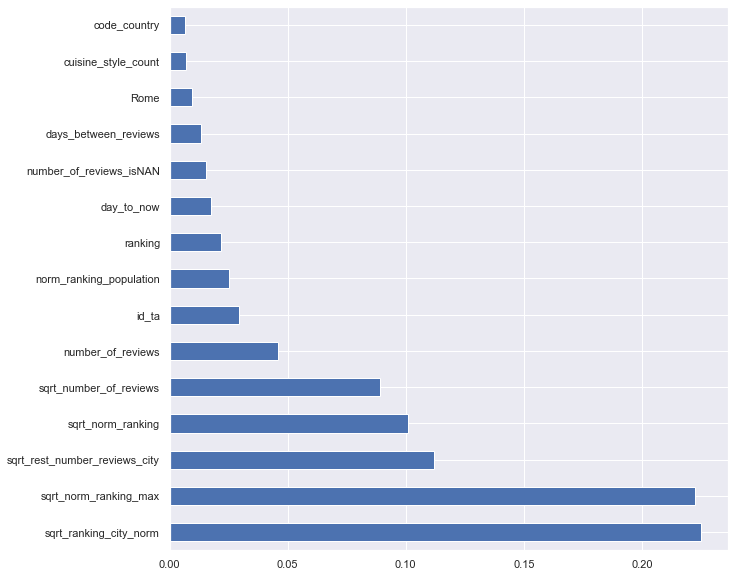

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [62]:
# готовим Submission на кагл
test_data = test_data.drop(['rating'], axis=1)

predict_submission = model.predict(test_data)

sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


,Restaurant_id,Rating
0,id_0,3.125
1,id_1,4.225
2,id_2,4.385
3,id_3,4.360
4,id_4,4.410
5,id_5,4.450
6,id_6,1.775
7,id_7,2.885
8,id_8,4.200
9,id_9,4.515


https://nagornyy.me/courses/data-science/feature_engineering/

http://shad.yandex.ru/lectures/machine_learning.xml


http://shad.yandex.ru/lectures/machine_learning_13.xml


www.machinelearning.ru/
